# Gaussian Process for Event likelihoods

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
const AGP = AugmentedGaussianProcesses
using Distributions

## Creating some random data

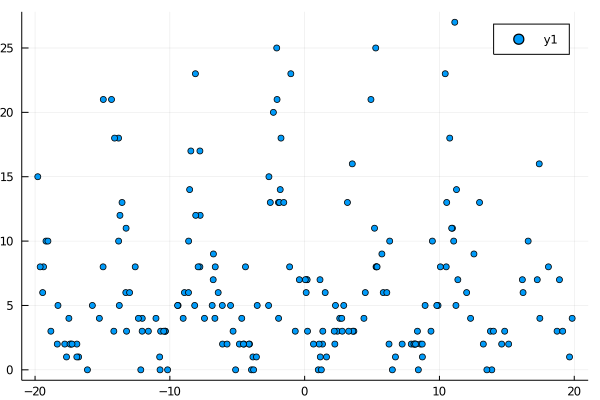

In [2]:
n_data = 200
X = (rand(n_data) .- 0.5) * 40
r = 5.0
Y = rand.(NegativeBinomial.(r, AGP.logistic.(sin.(X))))
scatter(X, Y)

## Run GP model with negative binomial likelihood to learn p

In [3]:
kernel = SqExponentialKernel() ∘ ScaleTransform(1.0)
m_negbinomial = VGP(
    X, Y, kernel, NegBinomialLikelihood(r), AnalyticVI(); optimiser=false, verbose=2
)
@time train!(m_negbinomial, 20)

[ Info: Starting training Variational Gaussian Process with a Negative Binomial Likelihood (r = 5.0) infered by Analytic Variational Inference  with 200 samples, 200 features and 1 latent GP
Training Progress: 100%|████████████████████████████████| Time: 0:00:02
  iter:  20
  ELBO:  -584.5551763350625
[ Info: Training ended after 20 iterations. Total number of iterations 20
  3.291403 seconds (5.66 M allocations: 367.050 MiB, 98.27% compilation time)


## Running the same model but with a Poisson likelihood

In [4]:
kernel = SqExponentialKernel() ∘ ScaleTransform(1.0)
m_poisson = VGP(
    X, Y, kernel, PoissonLikelihood(r), AnalyticVI(); optimiser=false, verbose=2
)
@time train!(m_poisson, 20)

[ Info: Starting training Variational Gaussian Process with a Poisson Likelihood (λ = 5.0) infered by Analytic Variational Inference  with 200 samples, 200 features and 1 latent GP
Training Progress: 100%|████████████████████████████████| Time: 0:00:00
  iter:  20
  ELBO:  -700.2591845623217
[ Info: Training ended after 20 iterations. Total number of iterations 20
  1.799742 seconds (3.12 M allocations: 232.635 MiB, 95.65% compilation time)


Prediction and plot function on a grid
Create a grid and compute prediction on it

In [5]:
function compute_grid(model, n_grid=50)
    mins = -20
    maxs = 20
    x_grid = range(mins, maxs; length=n_grid) # Create a grid
    y_grid, sig_y_grid = proba_y(model, reshape(x_grid, :, 1)) # Predict the mean and variance on the grid
    return y_grid, sig_y_grid, x_grid
end

compute_grid (generic function with 2 methods)

Plot the data as a scatter plot

In [6]:
function plot_data(X, Y)
    return Plots.scatter(X, Y; alpha=0.33, msw=0.0, lab="", size=(800, 500))
end

function plot_model(model, X, Y, title=nothing)
    n_grid = 100
    y_grid, sig_y_grid, x_grid = compute_grid(model, n_grid)
    p = plot_data(X, Y)
    Plots.plot!(
        p,
        x_grid,
        y_grid;
        ribbon=2 * sqrt.(sig_y_grid), # Plot 2 std deviations
        title=title,
        color="red",
        lab="",
        linewidth=3.0,
    )
    if model isa SVGP # Plot the inducing points as well
        Plots.plot!(
            p,
            vec(model.f[1].Z),
            zeros(dim(model.f[1]));
            msize=2.0,
            color="black",
            t=:scatter,
            lab="",
        )
    end
    return p
end;

## Comparison between the two likelihoods

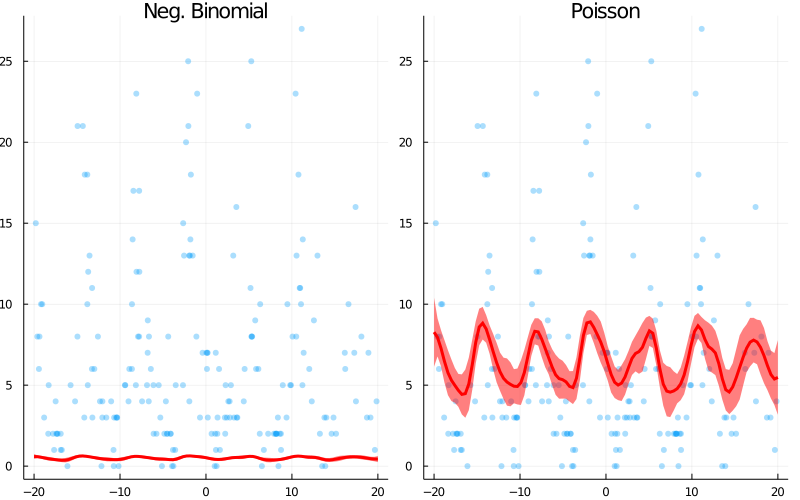

In [7]:
Plots.plot(
    plot_model.(
        [m_negbinomial, m_poisson], Ref(X), Ref(Y), ["Neg. Binomial", "Poisson"]
    )...;
    layout=(1, 2),
)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*